In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


events = pd.read_csv('hse-rec-sys-challenge-2024/events.csv')
item_features = pd.read_csv('hse-rec-sys-challenge-2024/item_features.csv')
user_features = pd.read_csv('hse-rec-sys-challenge-2024/user_features.csv')

In [105]:
user_features['gender'] = (user_features['gender'] == 'F') * 1

## EDA

In [106]:
# сначала посмотрим на пользователей
print('Количество уникальных пользователей:', user_features.user_id.nunique())
print('Доля женщин в выборке:', np.round(user_features.gender.mean(), 3))

print('Количество уникальных фильмов:', item_features.item_id.nunique())

Количество уникальных пользователей: 6040
Доля женщин в выборке: 0.283
Количество уникальных фильмов: 3706


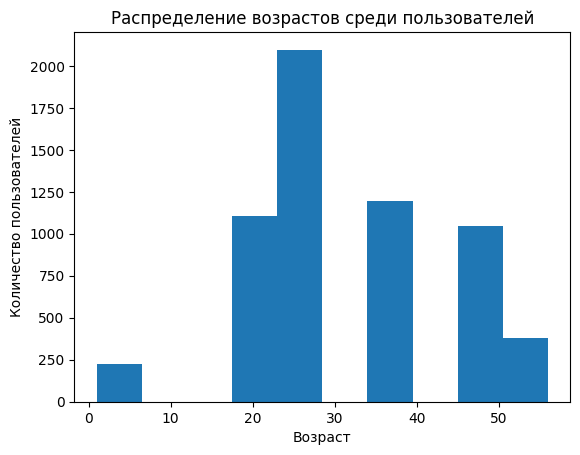

In [107]:
plt.hist(user_features.age)
plt.title('Распределение возрастов среди пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей');

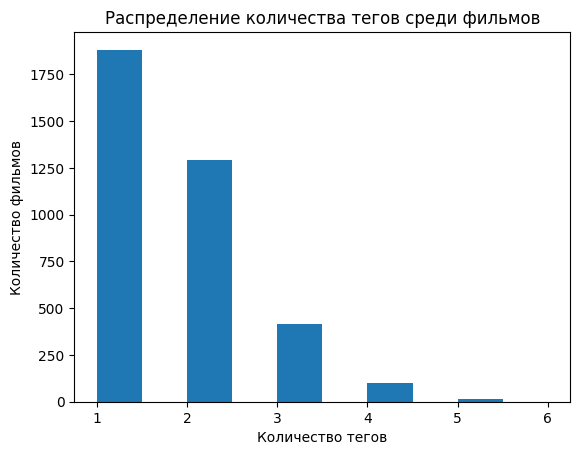

In [108]:
plt.hist(item_features.drop(columns=['item_id']).sum(axis=1).sort_values())
plt.title('Распределение количества тегов среди фильмов')
plt.xlabel('Количество тегов')
plt.ylabel('Количество фильмов');

## Добавим немного признаков
- Средняя оценка пользователя  $\checkmark$
- Средняя оценка фильма
- Распределение жанров по пользователю только по хорошим оценкам $\checkmark$
- Количество оценок до оценки текущего фильма $\checkmark$
- Количество просмотров фильма в базе
- Распределение жанров по пользователю $\checkmark$
- Популярность жанра во времени

In [109]:
# для этого для начала получим полный датасет, из которого будем получать необходимые данные
events_with_user_features = pd.merge(events, user_features, on=['user_id'], how='inner')
full_info_events = pd.merge(events_with_user_features, item_features, on=['item_id'], how='inner')

In [110]:
# посмотрим, есть ли пользователи или фильмы, которым не поставили оценку или которые не смотрели
print('Количество уникальных пользователей, которые поставили хотя бы одну оценку:',  full_info_events['user_id'].nunique())
print('Количество уникальных фильмов, которым поставили хотя бы одну оценку:', full_info_events['item_id'].nunique())

Количество уникальных пользователей, которые поставили хотя бы одну оценку: 6040
Количество уникальных фильмов, которым поставили хотя бы одну оценку: 3690


<Axes: xlabel='timestamp'>

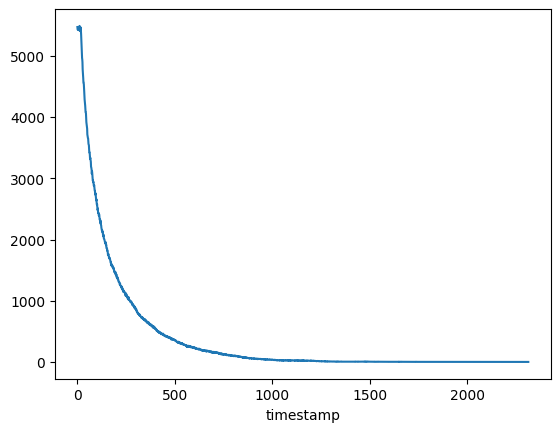

In [111]:
# немного поизучаем время - количество оценок, которые были проставлены в зависимости от отсечки.
full_info_events.sort_values('timestamp').groupby('timestamp')['rating'].count().plot()

Интересно, конечно

In [112]:
full_info_events

,user_id,item_id,rating,timestamp,gender,age,genre_0,genre_1,genre_2,genre_3,...,genre_8,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17
0,0,1505,4,0,0,35,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,1505,5,37,0,25,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13,1505,5,86,0,56,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,17,1505,5,12,0,25,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,24,1505,5,27,0,18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894144,5599,3263,3,364,0,18,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
894145,5740,865,4,695,0,25,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
894146,5747,2241,2,661,1,18,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
894147,5796,3542,3,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [113]:
genres = item_features.drop(columns=['item_id']).columns

In [114]:
user_genres = full_info_events.sort_values(['timestamp', 'item_id'])\
              .groupby('user_id')[genres].expanding().mean()\
              .reset_index(level=0)
user_genres['user_' + genres] = user_genres.groupby('user_id').shift(1).fillna(0)
user_genres.drop(columns=genres, inplace=True)

user_genres[285:290]

,user_id,user_genre_0,user_genre_1,user_genre_2,user_genre_3,user_genre_4,user_genre_5,user_genre_6,user_genre_7,user_genre_8,user_genre_9,user_genre_10,user_genre_11,user_genre_12,user_genre_13,user_genre_14,user_genre_15,user_genre_16,user_genre_17
251471,0,0.329825,0.214035,0.091228,0.150877,0.364912,0.070175,0.0,0.245614,0.066667,0.014035,0.077193,0.063158,0.045614,0.189474,0.164912,0.228070,0.059649,0.014035
251661,0,0.328671,0.213287,0.090909,0.150350,0.363636,0.069930,0.0,0.248252,0.066434,0.013986,0.076923,0.062937,0.045455,0.188811,0.164336,0.227273,0.059441,0.013986
12325,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
251977,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
252276,1,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000


In [115]:
user_ratings = full_info_events.sort_values(['timestamp', 'item_id'])\
              .groupby('user_id')['rating'].expanding().mean()\
              .reset_index(level=0)
user_genres['user_mean_rating'] = user_ratings.groupby('user_id').shift(1).fillna(0)
user_genres['user_cnt_rating'] = full_info_events.sort_values(['timestamp', 'item_id'])\
              .groupby('user_id')['rating'].cumcount()

In [116]:
full_info_new = pd.concat([full_info_events.sort_values(['user_id', 'timestamp', 'item_id']), user_genres.drop(columns=['user_id'])], axis=1)

In [117]:
full_info_new['liked_' + genres] = full_info_new.loc[full_info_new['rating'] >=4, genres]

In [118]:
user_liked_features = full_info_new\
.sort_values(['user_id', 'timestamp', 'item_id'])\
.groupby('user_id')['liked_' + genres].expanding().mean().reset_index(drop=True)

In [119]:
full_info_liked = pd.concat([full_info_new, user_liked_features], axis=1)

In [120]:
from lightfm.data import Dataset
from lightfm import LightFM

dataset = Dataset()
dataset.fit(full_info_liked['user_id'].unique(), full_info_liked['item_id'].unique())
interactions_matrix, weights_matrix = dataset.build_interactions(
    zip(*full_info_liked[['user_id', 'item_id', 'rating']].values.T)
)

weights_matrix_csr = weights_matrix.tocsr()

In [121]:
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'items_mapping': lightfm_mapping[2],
}

lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

print(f"users_mapping amount: {len(lightfm_mapping['users_mapping'])}")
print(f"items_mapping amount: {len(lightfm_mapping['items_mapping'])}")

users_mapping amount: 6040
items_mapping amount: 3690


In [122]:
from tqdm import tqdm

lfm_model = LightFM(
    no_components=32,
    learning_rate=0.1,
    loss='warp',
    max_sampled=5,
    random_state=42
)

num_epochs = 15

for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(
        weights_matrix_csr
    )

100%|██████████| 15/15 [00:05<00:00,  2.84it/s]


In [123]:
def generate_lightfm_recs_mapper(model, item_ids, known_items,
                                 user_features, item_features, N,
                                 user_mapping, item_inv_mapping,
                                 num_threads=1):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(user_id, item_ids, user_features=user_features,
                             item_features=item_features, num_threads=num_threads)

        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]

        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [124]:
candidates = pd.DataFrame({
    'user_id': full_info_liked['user_id'].unique()
})

candidates.head(3)

,user_id
0,0
1,1
2,2


In [125]:
# кол-во кандидатов
top_N = 150

# вспомогательные данные
all_cols = list(lightfm_mapping['items_mapping'].values())

mapper = generate_lightfm_recs_mapper(
    lfm_model,
    item_ids=all_cols,
    known_items=dict(),
    N=top_N,
    user_features=None,
    item_features=None,
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

In [126]:
import numpy as np

# генерируем предказания
candidates['item_id'] = candidates['user_id'].map(mapper)
candidates = candidates.explode('item_id')
candidates['rank'] = candidates.groupby('user_id').cumcount() + 1
candidates.head()

,user_id,item_id,rank
0,0,2297,1
0,0,3022,2
0,0,1583,3
0,0,1039,4
0,0,584,5


In [127]:
pos = candidates.merge(full_info_liked,
                        on=['user_id', 'item_id'],
                        how='inner')

pos['target'] = 1
print(pos.shape)
pos.head()

(364011, 82)


,user_id,item_id,rank,rating,timestamp,gender,age,genre_0,genre_1,genre_2,...,liked_genre_9,liked_genre_10,liked_genre_11,liked_genre_12,liked_genre_13,liked_genre_14,liked_genre_15,liked_genre_16,liked_genre_17,target
0,0,2297,1,4,113,0,35,1,1,0,...,0.000000,0.062500,0.000000,0.000000,0.156250,0.187500,0.187500,0.062500,0.000000,1
1,0,3022,2,5,92,0,35,1,1,0,...,0.000000,0.000000,0.318182,0.000000,0.181818,0.000000,0.045455,0.000000,0.000000,1
2,0,1583,3,5,52,0,35,1,1,0,...,0.000000,0.030612,0.112245,0.000000,0.428571,0.051020,0.010204,0.102041,0.030612,1
3,0,1039,4,5,59,0,35,1,1,0,...,0.095238,0.035714,0.067460,0.091270,0.226190,0.119048,0.162698,0.119048,0.015873,1
4,0,584,5,4,2,0,35,1,1,0,...,0.064516,0.064516,0.032258,0.064516,0.161290,0.032258,0.064516,0.096774,0.032258,1


In [128]:
neg = candidates.set_index(['user_id', 'item_id'])\
        .join(full_info_liked.set_index(['user_id', 'item_id']))

neg = neg[neg['rating'].isnull()].reset_index()
neg = pd.merge(pd.merge(neg[['user_id', 'item_id', 'rank']], item_features, on=['item_id']), user_features, on=['user_id'])

# neg = neg.sample(frac=0.07)
neg['target'] = 0

neg.shape

(541989, 24)

In [129]:
train = pd.concat([pos[neg.columns], neg])
train['target'].mean()

0.40177814569536424

In [130]:
neg

,user_id,item_id,rank,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,...,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,gender,age,target
0,0,1811,10,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,35,0
1,0,2256,26,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,35,0
2,0,2732,34,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,35,0
3,0,3298,37,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,35,0
4,0,1001,44,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541984,401,730,139,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,45,0
541985,2257,573,61,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,50,0
541986,2257,2230,86,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,50,0
541987,2257,3653,110,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,50,0


In [131]:
train['target'].mean()

0.40177814569536424

In [132]:
X_train = train.drop(columns=['target', 'item_id', 'user_id'])
y_train = train['target']

In [133]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier()
cb.fit(X_train, y_train)

Learning rate set to 0.188637
0:	learn: 0.6762611	total: 41.9ms	remaining: 41.8s
1:	learn: 0.6652100	total: 72.1ms	remaining: 36s
2:	learn: 0.6579158	total: 137ms	remaining: 45.5s
3:	learn: 0.6530018	total: 168ms	remaining: 41.7s
4:	learn: 0.6496921	total: 196ms	remaining: 39s
5:	learn: 0.6474750	total: 225ms	remaining: 37.2s
6:	learn: 0.6458643	total: 252ms	remaining: 35.8s
7:	learn: 0.6446535	total: 284ms	remaining: 35.2s
8:	learn: 0.6438086	total: 312ms	remaining: 34.3s
9:	learn: 0.6431943	total: 339ms	remaining: 33.6s
10:	learn: 0.6427722	total: 372ms	remaining: 33.5s
11:	learn: 0.6424820	total: 400ms	remaining: 33s
12:	learn: 0.6421937	total: 437ms	remaining: 33.2s
13:	learn: 0.6419589	total: 476ms	remaining: 33.5s
14:	learn: 0.6417902	total: 514ms	remaining: 33.8s
15:	learn: 0.6416518	total: 551ms	remaining: 33.9s
16:	learn: 0.6415157	total: 589ms	remaining: 34.1s
17:	learn: 0.6413786	total: 628ms	remaining: 34.2s
18:	learn: 0.6413011	total: 664ms	remaining: 34.3s
19:	learn: 0.64

In [134]:
train['score'] = -cb.predict_proba(X_train)[:, 1]

In [135]:
train.loc[train['target'] != 1, ['item_id', 'user_id', 'score']]\
.sort_values(['user_id', 'score'])

,item_id,user_id,score
1,2256,0,-0.539998
4,1001,0,-0.529895
2,2732,0,-0.520469
0,1811,0,-0.518984
8,2397,0,-0.483400
...,...,...,...
503454,3665,6039,-0.267957
503420,1668,6039,-0.266258
503414,69,6039,-0.261666
503422,2110,6039,-0.246732


In [136]:
submission_attempt = train.loc[train['target'] != 1, ['item_id', 'user_id', 'score']]\
.sort_values(['user_id', 'score'])\
.groupby('user_id').head(10)\
.groupby('user_id')['item_id']\
.apply(list).reset_index()

submission_attempt['item_id'] = submission_attempt['item_id'].apply(lambda x: ' '.join(map(str, x)))

In [137]:
submission_attempt.to_csv('submission_attempt_final.csv', index=False)